In [4]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

SUSCEPTIBLE = "S"
EXPOSED = "E"
INFECTED = "I"
RECOVERED = "R"

class Agent:
    def __init__(self, agent_id, susceptibility, social_influence, information_sharing, health_state):
        self.agent_id = agent_id
        self.susceptibility = susceptibility  # How likely to believe misinformation
        self.social_influence = social_influence  # Influence strength on neighbors
        self.information_sharing = information_sharing  # How likely to share misinformation
        self.health_state = health_state  # Epidemic state (S, E, I, R)
        self.beliefs = {}  # Beliefs about misinformation

class BeliefPropagationModel:
    def __init__(self):
        self.graph = nx.Graph()

    def add_agent(self, agent):
        self.graph.add_node(agent.agent_id, agent=agent)

    def add_connection(self, agent1_id, agent2_id, weight=1):
        self.graph.add_edge(agent1_id, agent2_id, weight=weight)

    def propagate_beliefs(self, tweet_beliefs, iterations=5):
        """Simulate belief propagation on the network."""
        for _ in range(iterations):
            for agent_id in self.graph.nodes:
                agent = self.graph.nodes[agent_id]['agent']
                # Combine neighbors' beliefs
                neighbor_beliefs = []
                for neighbor in self.graph.neighbors(agent_id):
                    neighbor_agent = self.graph.nodes[neighbor]['agent']
                    neighbor_beliefs.append(neighbor_agent.beliefs.get(tweet_beliefs, 0))
                # Update agent's belief
                if neighbor_beliefs:
                    avg_belief = np.mean(neighbor_beliefs)
                    agent.beliefs[tweet_beliefs] = (1 - agent.susceptibility) * agent.beliefs.get(tweet_beliefs, 0) + agent.susceptibility * avg_belief

    def simulate_epidemic(self, beta, sigma, gamma, steps=10):
        """Simulate the SEIR epidemic model."""
        results = []
        for _ in range(steps):
            new_exposed = []
            new_infected = []
            new_recovered = []
            for agent_id in self.graph.nodes:
                agent = self.graph.nodes[agent_id]['agent']
                if agent.health_state == SUSCEPTIBLE:
                    # Check for exposure
                    for neighbor in self.graph.neighbors(agent_id):
                        neighbor_agent = self.graph.nodes[neighbor]['agent']
                        if neighbor_agent.health_state == INFECTED:
                            if np.random.rand() < beta:
                                new_exposed.append(agent_id)
                                break
                elif agent.health_state == EXPOSED:
                    if np.random.rand() < sigma:
                        new_infected.append(agent_id)
                elif agent.health_state == INFECTED:
                    if np.random.rand() < gamma:
                        new_recovered.append(agent_id)

            # Update states
            for agent_id in new_exposed:
                self.graph.nodes[agent_id]['agent'].health_state = EXPOSED
            for agent_id in new_infected:
                self.graph.nodes[agent_id]['agent'].health_state = INFECTED
            for agent_id in new_recovered:
                self.graph.nodes[agent_id]['agent'].health_state = RECOVERED

            # Record statistics
            counts = {SUSCEPTIBLE: 0, EXPOSED: 0, INFECTED: 0, RECOVERED: 0}
            for agent_id in self.graph.nodes:
                counts[self.graph.nodes[agent_id]['agent'].health_state] += 1
            results.append(counts)

        return results

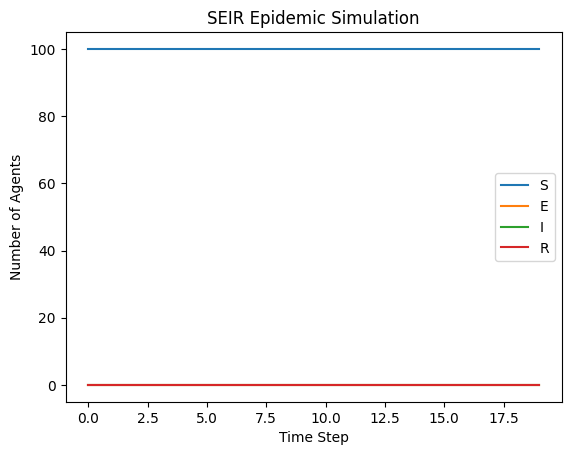

In [5]:
path = '05-01-2020/'
claims_fake_data = pd.read_csv(path + 'ClaimFakeCOVID-19.csv')
tweets_data = pd.read_csv(path + 'ClaimFakeCOVID-19_tweets.csv')
replies_data = pd.read_csv(path + 'ClaimFakeCOVID-19_tweets_replies.csv')

valid_claim_ids = set(claims_fake_data['fact_check_url'])
tweets_data['valid'] = tweets_data['tweet_id'].isin(valid_claim_ids)
replies_data['valid'] = replies_data['news_id'].isin(valid_claim_ids)

model = BeliefPropagationModel()

# Add Agents
for i in range(100):
    susceptibility = np.random.uniform(0.1, 0.5)
    social_influence = np.random.uniform(0.1, 0.5)
    information_sharing = np.random.uniform(0.1, 0.5)
    health_state = SUSCEPTIBLE
    model.add_agent(Agent(i, susceptibility, social_influence, information_sharing, health_state))

for _ in range(300):
    a, b = np.random.choice(100, 2, replace=False)
    model.add_connection(a, b)

model.propagate_beliefs(tweet_beliefs='fake', iterations=10)

results = model.simulate_epidemic(beta=0.2, sigma=0.1, gamma=0.05, steps=20)

stats = pd.DataFrame(results)
stats.plot()
plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.title('SEIR Epidemic Simulation')
plt.show()

In [6]:
valid_claim_ids

{'medicalnewstoday.com'}

In [7]:
tweets_data

,index,tweet_id,valid
0,100001,1252630938770649089,False
1,100001,1243968198111789058,False
2,100001,1242474839966765056,False
3,100001,1242461115616866304,False
4,100001,1242400142335983619,False
...,...,...,...
452,100022,1243151242194489345,False
453,100022,1240247344131493888,False
454,100022,1236627989036781569,False
455,100023,1245392712607694860,False


In [8]:
replies_data

,news_id,tweet_id,reply_id,valid
0,100001,1242474839966765056,1242474835512446976,False
1,100001,1242474839966765056,1242474843137703938,False
2,100001,1242400142335983619,1242388627943878657,False
3,100001,1242400142335983619,1242400453700096001,False
4,100003,1248606541793488896,1248609022841729028,False
...,...,...,...,...
618,100022,1251517138126270465,1251517138969300994,False
619,100022,1240247344131493888,1240234698053431305,False
620,100022,1240247344131493888,1240235078887837699,False
621,100022,1240247344131493888,1240242272324571136,False
